In [69]:
import os
import pandas as pd
import tarfile
import numpy as np
import string
import spacy 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from spellchecker import SpellChecker
import traceback
import joblib
from tqdm import tqdm
import kagglehub

tqdm.pandas()

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
dataset_handle = "kritanjalijain/amazon-reviews"

tgz_path = kagglehub.dataset_download(dataset_handle, "amazon_review_polarity_csv.tgz")

In [18]:
os.makedirs("./_resources/models", exist_ok=True)
print(tgz_path)

C:\Users\2024\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2\amazon_review_polarity_csv.tgz


In [19]:
with tarfile.open(tgz_path, 'r:gz') as tar:
    _base = 'amazon_review_polarity_csv'
    train_member = tar.getmember(f"{_base}/train.csv")
    with tar.extractfile(train_member) as f:
        train_df = pd.read_csv(f, header=None, names=["label", "title", "description"])
    
    with tar.extractfile(tar.getmember(f"{_base}/test.csv")) as f:
        test_df = pd.read_csv(f, header=None, names=["label", "title", "description"])

In [20]:
train_df.head()

,label,title,description
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [21]:
test_df.head()

,label,title,description
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [22]:
print("Train Data Size: ", train_df.shape, "\nTest Data Size: ", test_df.shape)

Train Data Size:  (3600000, 3) 
Test Data Size:  (400000, 3)


In [23]:
train_df.dtypes

label           int64
title          object
description    object
dtype: object

In [24]:
train_df = train_df.astype({'label': 'category', 'title': str, 'description': str})
test_df = test_df.astype({'label': 'category', 'title': str, 'description': str})

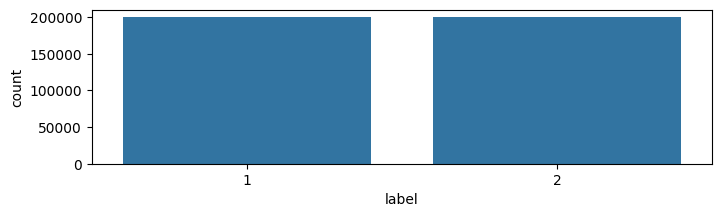

In [25]:
plt.figure(figsize=(8, 2))
sns.countplot(x='label', data=test_df)
plt.show()

In [45]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.spell = SpellChecker()

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        return pd.Series(self._preprocess_sentences(X), index=X.index)

    def _preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Collapse
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)
        # repeated-letter tokens 'a', 'bb', 'ccc'
        text = re.sub(r'\b([a-z])\1*\b', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s+', ' ', text).strip()
        _tokens = re.findall(r'\b[a-z]+\b', text)

        return ' '.join(self._lemmatized_spelling(_tokens))
    
    def _lemmatized_spelling(self, _tokens):
        tokens = []
        for token in _tokens:
            if token in stop_words:
                continue
            
            # if token not in self.spell:
            #     token = re.sub(r'(.)\1+', r'\1', token)
            #     corrected = self.spell.correction(token)
            #     token = corrected if corrected else token

            tokens.append(self.lemmatizer.lemmatize(token))

        return tokens

    def _preprocess_sentences(self, sentences):
        return sentences.progress_apply(self._preprocess_text)
 
preprocessor = TextPreprocessor()

In [46]:
empty_mask = train_df['title'].isna() | (train_df['title'].str.strip() == '')
train_df[empty_mask]

,label,title,description


In [47]:
train_df.drop_duplicates(subset=['description'], inplace=True)
test_df.drop_duplicates(subset=['description'], inplace=True)

In [48]:
print("Train Data Size: ", train_df.shape, "\nTest Data Size: ", test_df.shape)

Train Data Size:  (3594783, 3) 
Test Data Size:  (399917, 3)


In [49]:
# Reduce training data to half, testing data to 3/4
reduced_train_df = train_df.sample(frac=0.15, random_state=42)
reduced_test_df = test_df.sample(frac=0.75, random_state=42)

print("New Train Data Size:", reduced_train_df.shape)
print("New Test Data Size:", reduced_test_df.shape)

New Train Data Size: (539217, 3)
New Test Data Size: (299938, 3)


In [50]:
reduced_train_df.loc[:, 'description'] = preprocessor.transform(reduced_train_df['description'])

100%|██████████| 539217/539217 [02:57<00:00, 3033.66it/s]


In [53]:
reduced_test_df.loc[:, 'description'] = preprocessor.transform(reduced_test_df['description'])

100%|██████████| 299938/299938 [01:40<00:00, 2986.67it/s]


In [54]:
reduced_train_df.to_csv('./_resources/preprocessed_train.csv', index=False)
reduced_test_df.to_csv('./_resources/preprocessed_test.csv', index=False)

In [55]:
processed_train_df = pd.read_csv('./_resources/preprocessed_train.csv').astype({
	'label': 'category', 'title': str, 'description': str
})
processed_test_df = pd.read_csv('./_resources/preprocessed_test.csv').astype({
	'label': 'category', 'title': str, 'description': str
})

In [56]:
X_train, y_train = processed_train_df['description'], processed_train_df['label']
X_test, y_test = processed_test_df['description'], processed_test_df['label']

In [57]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf.fit(X_train)
joblib.dump(tfidf, './_resources/models/tfidf_vectorizer.joblib')

['./_resources/models/tfidf_vectorizer.joblib']

In [58]:
tfidf = joblib.load('./_resources/models/tfidf_vectorizer.joblib')

In [59]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("No. of features extracted:")
print(len(tfidf.vocabulary_))

No. of features extracted:
7235504


In [60]:
words = tfidf.get_feature_names_out()

In [89]:
class ModelEvaluator:
    def __init__(self, models: list):
        self.models = models
        self.results = []
        self.trained_models = []

    def evaluate(self, X_train, y_train, X_test, y_test):
        for model_cfg in tqdm(self.models, desc="Evaluating Models", unit="model"):
            model_name = model_cfg.get('name', 'Unnamed Model')
            try:
                model = model_cfg['model'](**model_cfg.get('params', {}))
                model.fit(X_train, y_train)  # train
                y_pred = model.predict(X_test)

                metrics = {
                    'Model': model_name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred, zero_division=0),
                    'Recall': recall_score(y_test, y_pred, zero_division=0),
                    'F1 Score': f1_score(y_test, y_pred, zero_division=0),
                    'Trained': True
                }
                self.results.append(metrics)
                self.trained_models.append({
                    'name': model_name,
                    'instance': model
                })

            except Exception as e:
                print(f"\nModel '{model_name}' failed:\n{traceback.format_exc()}")
                self.results.append({'Model': model_name,'Accuracy': None,'Precision': None,'Recall': None,'F1 Score': None,'Trained': False,'Error': str(e)})

        df = pd.DataFrame(self.results)
        return df.sort_values(by='Accuracy', ascending=False, na_position='last').reset_index(drop=True)

    def save_models(self, save_dir: str = "./_resources/models"):
        os.makedirs(save_dir, exist_ok=True)
        pd.DataFrame(self.results).to_csv("./_resources/evaluations.csv", index=False)

        for tm in self.trained_models:
            model_name = tm['name'].lower().replace(' ', '_')
            filename = os.path.join(save_dir, f"{model_name}.pkl")
            joblib.dump(tm['instance'], filename)
            print(f"Saved trained model: {filename}")

    def is_trained(self, model_name: str) -> bool:
        return any(m['name'] == model_name for m in self.trained_models)

In [90]:
models = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression,
        'params': {'C': 0.1, 'solver': 'saga','max_iter': 5000, 'random_state': 42}
    },
    {
        'name': 'Multinomial NaiveBayes',
        'model': MultinomialNB,
        'params': {'alpha': 0.5}
    }
]

evaluator = ModelEvaluator(models)

In [91]:
results_df = evaluator.evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test)
results_df

Evaluating Models: 100%|██████████| 2/2 [00:52<00:00, 26.45s/model]


,Model,Accuracy,Precision,Recall,F1 Score,Trained
0,Multinomial NaiveBayes,0.862402,0.854601,0.873616,0.864003,True
1,Logistic Regression,0.859901,0.861831,0.857449,0.859635,True


In [93]:
evaluator.save_models()

Saved trained model: ./_resources/models\logistic_regression.pkl
Saved trained model: ./_resources/models\multinomial_naivebayes.pkl


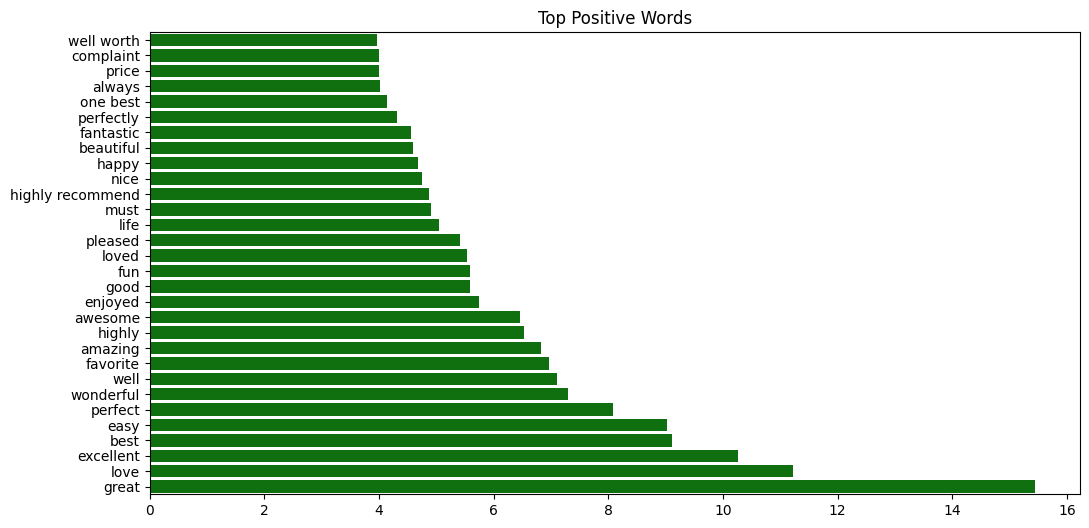

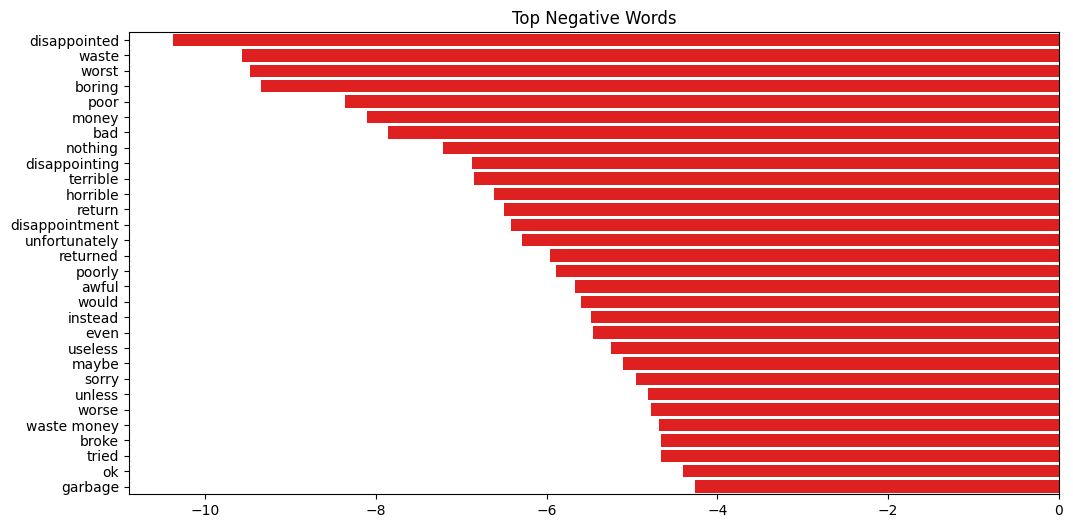

In [100]:
feature_names = np.array(words)

coef = evaluator.trained_models[0]['instance'].coef_.ravel()
top_pos_indices = np.argsort(coef)[-30:]
top_neg_indices = np.argsort(coef)[:30]

plt.figure(figsize=(12, 6))
sns.barplot(x=coef[top_pos_indices], y=feature_names[top_pos_indices], color='green')
plt.title("Top Positive Words")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=coef[top_neg_indices], y=feature_names[top_neg_indices], color='red')
plt.title("Top Negative Words")
plt.show()